## Clone the Repository

In [1]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

Cloning into 'fastercnn-pytorch-training-pipeline'...
remote: Enumerating objects: 1452, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 1452 (delta 371), reused 333 (delta 322), pack-reused 984 (from 2)
Receiving objects: 100% (1452/1452), 13.03 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (974/974), done.
Updating files: 100% (85/85), done.


In [3]:
# Enter the repo directory.
%cd fastercnn-pytorch-training-pipeline/

/workspace/fastercnn-pytorch-training-pipeline


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# Install the Requirements
!pip install -r requirements.txt

## Download the Dataset

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="ZACzFJOvzbToDyklrMEb")
# project = rf.workspace("ctufinalthesis").project("drowsinessdetectionyolov8-test2")
# version = project.version(9)
# dataset = version.download("voc")

In [ ]:
# !curl -L "https://public.roboflow.com/ds/CNyGy97q45?key=eSpwiC1Ah7" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip

In [5]:
# %%capture
# !apt install zip

In [ ]:
%%capture
!curl -L "https://universe.roboflow.com/ds/xReu2dBLp1?key=fRmKwival1" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

## Create the Custom Dataset YAML File.

In [9]:
pwd

'/workspace/fastercnn-pytorch-training-pipeline'

In [28]:
%%writefile data_configs/custom_data.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: 'train'
TRAIN_DIR_LABELS: 'train'
VALID_DIR_IMAGES: 'valid'
VALID_DIR_LABELS: 'valid'
TEST_DIR_IMAGES: 'test'
TEST_DIR_LABELS: 'test'


# Class names.
CLASSES: [
    '__background__',
    'Drowsy', 'Awake'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 3

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Overwriting data_configs/custom_data.yaml


In [11]:
try:
    get_ipython()
    print("You're in an IPython/Jupyter environment.")
except:
    print("You're NOT in a Jupyter environment.")

You're in an IPython/Jupyter environment.


In [26]:
pwd

'/workspace/fastercnn-pytorch-training-pipeline'

In [27]:
# %%writefile data_configs/custom_data.yaml
# # Images and labels directory should be relative to train.py
# TRAIN_DIR_IMAGES: '/train/images'
# TRAIN_DIR_LABELS: '/train/labels'

# VALID_DIR_IMAGES: '/valid/images'
# VALID_DIR_LABELS: '/valid/labels'

# TEST_DIR_IMAGES: '/test/images'
# TEST_DIR_LABELS: '/test/labels'

# # Class names (first is background).
# CLASSES: [
#     '__background__',
#     'Drowsy',
#     'Awake'
# ]

# # Number of classes (object classes + 1 for background class in Faster RCNN).
# NC: 3

# # Whether to save the predictions of the validation set while training.
# SAVE_VALID_PREDICTION_IMAGES: True


Overwriting data_configs/custom_data.yaml


In [18]:
pwd

'/workspace/fastercnn-pytorch-training-pipeline'

In [19]:
%%writefile utils/transforms.py
import albumentations as A
import numpy as np
import cv2

from albumentations.pytorch import ToTensorV2
from torchvision import transforms as transforms

def resize(im, img_size=640, square=False):
    if square:
        im = cv2.resize(im, (img_size, img_size))
    else:
        h0, w0 = im.shape[:2]
        r = img_size / max(h0, w0)
        if r != 1:
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
    return im

def get_train_aug():
    return A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.ToGray(p=0.1),
        A.RandomBrightnessContrast(p=0.1),
        A.ColorJitter(p=0.1),
        A.RandomGamma(p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['category_id'],
    ))

def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['category_id'],
    ))

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['category_id'],
    ))

def infer_transforms(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    return transform(image)

def transform_mosaic(mosaic, boxes, img_size=640):
    aug = A.Compose([
        A.Resize(img_size, img_size, always_apply=True, p=1.0)
    ])
    sample = aug(image=mosaic)
    resized_mosaic = sample['image']

    transformed_boxes = (np.array(boxes) / mosaic.shape[0]) * resized_mosaic.shape[1]
    for box in transformed_boxes:
        if box[2] - box[0] <= 1.0:
            box[2] += 1.0 - (box[2] - box[0])
            box[2] = min(box[2], float(resized_mosaic.shape[1]))
        if box[3] - box[1] <= 1.0:
            box[3] += 1.0 - (box[3] - box[1])
            box[3] = min(box[3], float(resized_mosaic.shape[0]))
    return resized_mosaic, transformed_boxes

Overwriting utils/transforms.py


In [20]:
%%writefile datasets.py
import torch
import cv2
import numpy as np
import os
import glob as glob
import random

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from utils.transforms import (
    get_train_transform,
    get_valid_transform,
    get_train_aug,
    transform_mosaic
)
from tqdm.auto import tqdm

class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size,
        classes,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
        label_type='pascal_voc'
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.square_training = square_training
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []
        self.log_annot_issue_x = True
        self.mosaic = mosaic
        self.log_annot_issue_y = True
        self.label_type = label_type

        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.images_path, file_type)))
        self.all_annot_paths = glob.glob(os.path.join(self.labels_path, '*.xml'))
        self.all_images = sorted([os.path.basename(p) for p in self.all_image_paths])
        if self.label_type == 'pascal_voc':
            self.read_and_clean()

    def read_and_clean(self):
        print('Checking Labels and images...')
        images_to_remove = []
        problematic_images = []

        for image_name in tqdm(self.all_images):
            possible_annot_name = os.path.join(self.labels_path, os.path.splitext(image_name)[0]+'.xml')
            if possible_annot_name not in self.all_annot_paths:
                print(f"⚠️ {possible_annot_name} not found... Removing {image_name}")
                images_to_remove.append(image_name)
                continue

            tree = et.parse(possible_annot_name)
            root = tree.getroot()
            invalid_bbox = False
            for member in root.findall('object'):
                xmin = float(member.find('bndbox').find('xmin').text)
                xmax = float(member.find('bndbox').find('xmax').text)
                ymin = float(member.find('bndbox').find('ymin').text)
                ymax = float(member.find('bndbox').find('ymax').text)
                if xmin >= xmax or ymin >= ymax:
                    invalid_bbox = True
                    break
            if invalid_bbox:
                problematic_images.append(image_name)
                images_to_remove.append(image_name)

        self.all_images = [img for img in self.all_images if img not in images_to_remove]
        self.all_annot_paths = [path for path in self.all_annot_paths
                                if os.path.splitext(os.path.basename(path))[0] not in [os.path.splitext(x)[0] for x in images_to_remove]]

        if problematic_images:
            print("\n⚠️ The following images have invalid bounding boxes and will be removed:")
            for img in problematic_images:
                print(f"⚠️ {img}")
        print(f"Removed {len(images_to_remove)} problematic images and annotations.")

    def resize(self, im, square=False):
        if square:
            return cv2.resize(im, (self.img_size, self.img_size))
        h0, w0 = im.shape[:2]
        r = self.img_size / max(h0, w0)
        if r != 1:
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
        return im

    def load_image_and_labels(self, index):
        image_name = self.all_images[index]
        image_path = os.path.join(self.images_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = self.resize(image, square=self.square_training)
        image_resized /= 255.0

        if self.label_type == 'pascal_voc':
            return self.load_pascal_voc(image, image_name, image_resized)
        elif self.label_type == 'yolo':
            return self.load_yolo(image, image_name, image_resized)

    def load_pascal_voc(self, image, image_name, image_resized):
        annot_file = os.path.join(self.labels_path, os.path.splitext(image_name)[0] + '.xml')
        boxes, orig_boxes, labels = [], [], []
        h, w = image.shape[:2]

        tree = et.parse(annot_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            labels.append(self.classes.index(obj.find('name').text))
            bnd = obj.find('bndbox')
            xmin, xmax = float(bnd.find('xmin').text), float(bnd.find('xmax').text)
            ymin, ymax = float(bnd.find('ymin').text), float(bnd.find('ymax').text)
            xmin, ymin, xmax, ymax = self.check_image_and_annotation(xmin, ymin, xmax, ymax, w, h, True)
            orig_boxes.append([xmin, ymin, xmax, ymax])
            xmin, ymin, xmax, ymax = [coord * scale for coord, scale in zip(
                [xmin/w, ymin/h, xmax/w, ymax/h],
                [image_resized.shape[1], image_resized.shape[0], image_resized.shape[1], image_resized.shape[0]]
            )]
            xmin, ymin, xmax, ymax = self.check_image_and_annotation(xmin, ymin, xmax, ymax, image_resized.shape[1], image_resized.shape[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) if len(boxes) > 0 else torch.as_tensor(boxes)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64) if len(boxes) > 0 else torch.as_tensor(boxes)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        return image, image_resized, orig_boxes, boxes, labels, area, iscrowd, (w, h)

    def check_image_and_annotation(self, xmin, ymin, xmax, ymax, width, height, orig_data=False):
        xmax = min(xmax, width)
        ymax = min(ymax, height)
        if xmax - xmin <= 1.0:
            xmin -= 1
        if ymax - ymin <= 1.0:
            ymin -= 1
        return xmin, ymin, xmax, ymax

    def load_cutmix_image_and_boxes(self, index):
        s = self.img_size
        yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]
        indices = [index] + [random.randint(0, len(self.all_images) - 1) for _ in range(3)]
        result_boxes, result_classes = [], []

        for i, idx in enumerate(indices):
            _, image_resized, _, boxes, labels, area, iscrowd, dims = self.load_image_and_labels(idx)
            h, w = image_resized.shape[:2]
            result_image = result_image if i != 0 else np.full((s * 2, s * 2, 3), 114/255, dtype=np.float32)
            x1a, y1a, x2a, y2a, x1b, y1b, x2b, y2b = self._get_coords(i, xc, yc, w, h, s)
            result_image[y1a:y2a, x1a:x2a] = image_resized[y1b:y2b, x1b:x2b]
            padw, padh = x1a - x1b, y1a - y1b

            if len(boxes) > 0:
                boxes[:, [0, 2]] += padw
                boxes[:, [1, 3]] += padh
                result_boxes.append(boxes)
                result_classes += labels

        final_boxes = np.concatenate(result_boxes, 0) if result_boxes else np.zeros((0, 4))
        final_boxes = np.clip(final_boxes, 0, 2 * s).astype(np.int32)
        final_classes = [result_classes[i] for i in range(len(final_boxes)) if (final_boxes[i, 2] - final_boxes[i, 0]) * (final_boxes[i, 3] - final_boxes[i, 1]) > 0]
        final_boxes = final_boxes[np.where((final_boxes[:, 2] - final_boxes[:, 0]) * (final_boxes[:, 3] - final_boxes[:, 1]) > 0)]
        result_image, final_boxes = transform_mosaic(result_image, final_boxes, self.img_size)

        return result_image, torch.tensor(final_boxes), torch.tensor(final_classes), area, iscrowd, dims

    def _get_coords(self, i, xc, yc, w, h, s):
        if i == 0:
            return max(xc - w, 0), max(yc - h, 0), xc, yc, w - (xc - max(xc - w, 0)), h - (yc - max(yc - h, 0)), w, h
        elif i == 1:
            return xc, max(yc - h, 0), min(xc + w, 2 * s), yc, 0, h - (yc - max(yc - h, 0)), min(w, min(xc + w, 2 * s) - xc), h
        elif i == 2:
            return max(xc - w, 0), yc, xc, min(2 * s, yc + h), w - (xc - max(xc - w, 0)), 0, max(xc, w), min(min(2 * s, yc + h) - yc, h)
        elif i == 3:
            return xc, yc, min(xc + w, 2 * s), min(yc + h, 2 * s), 0, 0, min(w, min(xc + w, 2 * s) - xc), min(min(yc + h, 2 * s) - yc, h)

    def __getitem__(self, idx):
        if self.train:
            if random.uniform(0.0, 1.0) < self.mosaic:
                image_resized, boxes, labels, area, iscrowd, dims = self.load_cutmix_image_and_boxes(idx)
            else:
                _, image_resized, _, boxes, labels, area, iscrowd, dims = self.load_image_and_labels(idx)
        else:
            _, image_resized, _, boxes, labels, area, iscrowd, dims = self.load_image_and_labels(idx)

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx])
        }

        labels_np = labels.cpu().numpy().tolist()
        bboxes = boxes.cpu().numpy().tolist()

        transform_func = get_train_aug() if self.use_train_aug else self.transforms
        sample = transform_func(image=image_resized, bboxes=bboxes, category_id=labels_np)
        image_resized = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)

        if target['boxes'].shape[0] == 0 or np.isnan(target['boxes'].numpy()).any():
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

        return image_resized, target

    def __len__(self):
        return len(self.all_images)

def collate_fn(batch):
    return tuple(zip(*batch))

def create_train_dataset(train_dir_images, train_dir_labels, img_size, classes, use_train_aug=False, mosaic=1.0, square_training=False, label_type='pascal_voc'):
    return CustomDataset(train_dir_images, train_dir_labels, img_size, classes, get_train_transform(), use_train_aug, True, mosaic, square_training, label_type)

def create_valid_dataset(valid_dir_images, valid_dir_labels, img_size, classes, square_training=False, label_type='pascal_voc'):
    return CustomDataset(valid_dir_images, valid_dir_labels, img_size, classes, get_valid_transform(), False, False, 0.0, square_training, label_type)

def create_train_loader(train_dataset, batch_size, num_workers=0, batch_sampler=None):
    return DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn, sampler=batch_sampler)

def create_valid_loader(valid_dataset, batch_size, num_workers=0, batch_sampler=None):
    return DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn, sampler=batch_sampler)


Overwriting datasets.py


## Training

In [1]:
%%capture
!pip install wandb
import wandb
wandb.login(key="0a94d4360e61cfe6a5a074216a1609078f0eb621")

In [6]:
!python train.py --data data_configs/custom_data.yaml --epochs 10 --model fasterrcnn_resnet50_fpn_v2 --name custom_training --batch 4 --workers 2

Not using distributed mode
wandb: Currently logged in as: farhan17wicaksono (farhan17wicaksono-sepuluh-nopember-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /workspace/fastercnn-pytorch-training-pipeline/wandb/run-20250625_140501-666uqs1p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run custom_training
wandb: ⭐️ View project at https://wandb.ai/farhan17wicaksono-sepuluh-nopember-institute-of-technology/fastercnn-pytorch-training-pipeline
wandb: 🚀 View run at https://wandb.ai/farhan17wicaksono-sepuluh-nopember-institute-of-technology/fastercnn-pytorch-training-pipeline/runs/666uqs1p
device cuda
/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Checking Labels and images...
100%|██████████████████████████████████████| 5166

## Visualize Validation Results

In [7]:
import matplotlib.pyplot as plt
import glob as glob

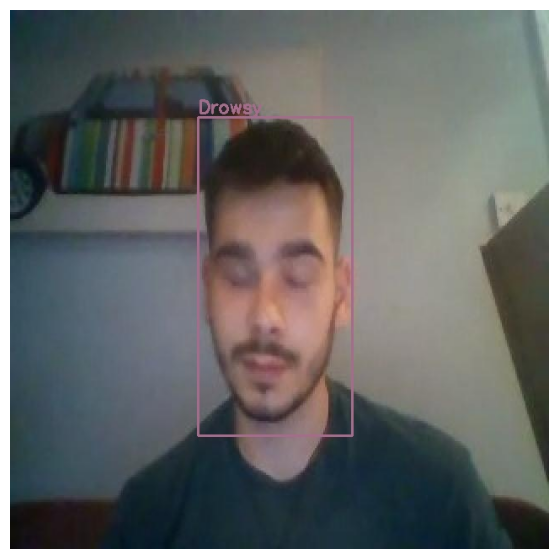

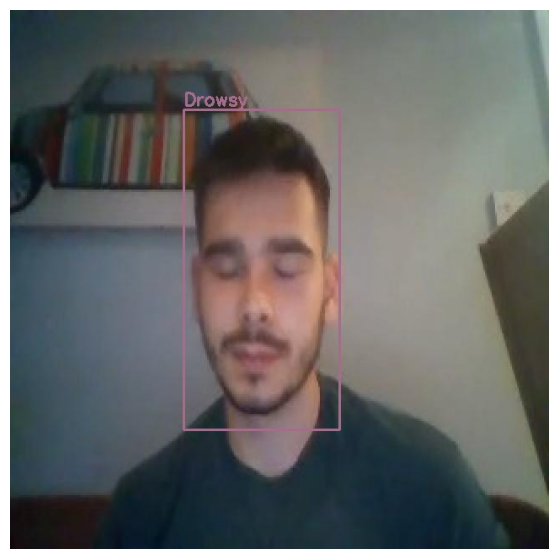

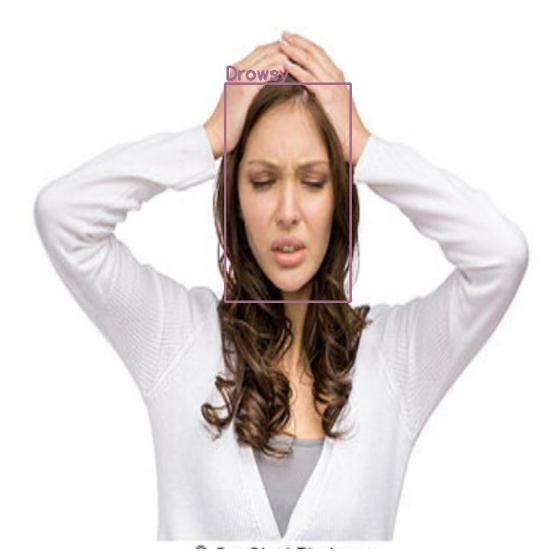

In [9]:
results_dir_path = 'outputs/training/custom_training'
valid_images = glob.glob(f"{results_dir_path}/*.jpg")

for i in range(3):
    plt.figure(figsize=(10, 7))
    image = plt.imread(valid_images[i])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Check Out the Repo for Latest Updates
https://github.com/sovit-123/fastercnn-pytorch-training-pipeline

## Evaluation

In [11]:
%%writefile eval.py
from datasets import (
    create_valid_dataset, create_valid_loader
)
from models.create_fasterrcnn_model import create_model
from torch_utils import utils
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch_utils.engine import evaluate as coco_evaluate
from torch_utils.coco_utils import get_coco_api_from_dataset
from torch_utils.coco_eval import CocoEvaluator
from pprint import pprint
from tqdm import tqdm

import torch
import argparse
import yaml
import time
import numpy as np

torch.multiprocessing.set_sharing_strategy('file_system')

def get_iou_types(model):
    model_without_ddp = model
    iou_types = ["bbox"]
    if hasattr(model_without_ddp, "mask_head") and model_without_ddp.mask_head is not None:
        iou_types.append("segm")
    if hasattr(model_without_ddp, "keypoint_head") and model_without_ddp.keypoint_head is not None:
        iou_types.append("keypoints")
    return iou_types

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', default='data_configs/test_image_config.yaml')
    parser.add_argument('-m', '--model', default='fasterrcnn_resnet50_fpn')
    parser.add_argument('-mw', '--weights', default=None)
    parser.add_argument('-ims', '--imgsz', default=640, type=int)
    parser.add_argument('-w', '--workers', default=4, type=int)
    parser.add_argument('-b', '--batch', default=8, type=int)
    parser.add_argument('-d', '--device', default=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    parser.add_argument('-v', '--verbose', action='store_true')
    parser.add_argument('-st', '--square-training', dest='square_training', action='store_true')
    args = vars(parser.parse_args())

    with open(args['data']) as file:
        data_configs = yaml.safe_load(file)

    try:
        VALID_DIR_IMAGES = data_configs['TEST_DIR_IMAGES']
        VALID_DIR_LABELS = data_configs['TEST_DIR_LABELS']
    except:
        VALID_DIR_IMAGES = data_configs['VALID_DIR_IMAGES']
        VALID_DIR_LABELS = data_configs['VALID_DIR_LABELS']

    NUM_CLASSES = data_configs['NC']
    CLASSES = data_configs['CLASSES']
    NUM_WORKERS = args['workers']
    DEVICE = args['device']
    BATCH_SIZE = args['batch']
    IMAGE_SIZE = args['imgsz']

    create_model_fn = create_model[args['model']]
    if args['weights'] is None:
        try:
            model, coco_model = create_model_fn(num_classes=NUM_CLASSES, coco_model=True)
        except:
            model = create_model_fn(num_classes=NUM_CLASSES, coco_model=True)
        if coco_model:
            COCO_91_CLASSES = data_configs['COCO_91_CLASSES']
            valid_dataset = create_valid_dataset(
                VALID_DIR_IMAGES,
                VALID_DIR_LABELS,
                IMAGE_SIZE,
                COCO_91_CLASSES,
                square_training=args['square_training']
            )

    if args['weights'] is not None:
        model = create_model_fn(num_classes=NUM_CLASSES, coco_model=False)
        checkpoint = torch.load(args['weights'], map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        valid_dataset = create_valid_dataset(
            VALID_DIR_IMAGES,
            VALID_DIR_LABELS,
            IMAGE_SIZE,
            CLASSES,
            square_training=args['square_training']
        )

    model.to(DEVICE).eval()
    valid_loader = create_valid_loader(valid_dataset, BATCH_SIZE, NUM_WORKERS)

    @torch.inference_mode()
    def evaluate(model, data_loader, device, out_dir=None, classes=None, colors=None):
        coco = get_coco_api_from_dataset(data_loader.dataset)
        iou_types = get_iou_types(model)
        coco_evaluator = CocoEvaluator(coco, iou_types)

        torchmetric_eval = MeanAveragePrecision(class_metrics=args['verbose'])

        cpu_device = torch.device("cpu")
        model.eval()

        target = []
        preds = []

        for images, targets in tqdm(data_loader, total=len(data_loader)):
            images = [img.to(device) for img in images]
            with torch.no_grad():
                outputs = model(images)

            res = {t["image_id"].item(): o for t, o in zip(targets, outputs)}
            coco_evaluator.update(res)

            for i in range(len(images)):
                true_dict = {
                    "boxes": targets[i]["boxes"].cpu(),
                    "labels": targets[i]["labels"].cpu(),
                }
                pred_dict = {
                    "boxes": outputs[i]["boxes"].cpu(),
                    "scores": outputs[i]["scores"].cpu(),
                    "labels": outputs[i]["labels"].cpu(),
                }
                preds.append(pred_dict)
                target.append(true_dict)

        coco_evaluator.synchronize_between_processes()
        coco_evaluator.accumulate()
        coco_evaluator.summarize()

        torchmetric_eval.update(preds, target)
        stats = torchmetric_eval.compute()
        return stats

    stats = evaluate(
        model,
        valid_loader,
        device=DEVICE,
        classes=CLASSES,
    )

    print('\n')
    pprint(stats)
    if args['verbose']:
        print('\n')
        pprint(f"Classes: {CLASSES}")
        print('\n')
        print('AP / AR per class')
        empty_string = ''
        if len(CLASSES) > 2:
            num_hyphens = 73
            print('-'*num_hyphens)
            print(f"|    | Class{empty_string:<16}| AP{empty_string:<18}| AR{empty_string:<18}|")
            print('-'*num_hyphens)
            for i in range(len(CLASSES)-1):
                print(f"|{i+1:<3} | {CLASSES[i+1]:<20} | {np.array(stats['map_per_class'][i]):.3f}{empty_string:<15}| {np.array(stats['mar_100_per_class'][i]):.3f}{empty_string:<15}|")
            print('-'*num_hyphens)
            print(f"|Avg{empty_string:<23} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")
        else:
            num_hyphens = 62
            print('-'*num_hyphens)
            print(f"|Class{empty_string:<10} | AP{empty_string:<18}| AR{empty_string:<18}|")
            print('-'*num_hyphens)
            print(f"|{CLASSES[1]:<15} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")
            print('-'*num_hyphens)
            print(f"|Avg{empty_string:<12} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")

Overwriting eval.py


In [12]:
# ! ls /content/fastercnn-pytorch-training-pipeline/test/images
# ! ls /content/fastercnn-pytorch-training-pipeline/test/labels


In [13]:
# No verbose mAP.
!python eval.py --weights outputs/training/custom_training/best_model.pth --data data_configs/custom_data.yaml --model fasterrcnn_resnet50_fpn_v2

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Checking Labels and images...
100%|████████████████████████████████████████| 564/564 [00:03<00:00, 162.96it/s]
Removed 0 problematic images and annotations.
creating index...
index created!
100%|███████████████████████████████████████████| 71/71 [00:20<00:00,  3.41it/s]
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.874
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.769
 Average R

In [14]:
# Verbose mAP.
!python eval.py --weights outputs/training/custom_training/best_model.pth --data data_configs/custom_data.yaml --model fasterrcnn_resnet50_fpn_v2 --verbose

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Checking Labels and images...
100%|████████████████████████████████████████| 564/564 [00:03<00:00, 169.18it/s]
Removed 0 problematic images and annotations.
creating index...
index created!
100%|███████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.874
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.769
 Average R